<a href="https://colab.research.google.com/github/hayTambourineMan/CSCI-6170/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Homework 3

## Dataset

I will be using the "Diabetes Health Indicators Dataset" from Kaggle. This dataset contains over 250,000 observations, enough data for training and testing deep learning models. The dataset includes 21 health-related features, many of which are binary, such as high blood pressure, physical activity, and smoking status. These indicators reflect lifestyle and medical conditions that are known risk factors for diabetes. The target variable is a categorical feature with three levels, representing no diabetes, pre-diabetes, and diabetes. So this will be a classification task. Link to the dataset is here: https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

In [14]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
# dataset
file_path = '/content/diabetes_012_health_indicators_BRFSS2015.csv'
data = pd.read_csv(file_path)
print(data.head())

   Diabetes_012  HighBP  HighChol  CholCheck   BMI  ...  DiffWalk  Sex   Age  Education  Income
0           0.0     1.0       1.0        1.0  40.0  ...       1.0  0.0   9.0        4.0     3.0
1           0.0     0.0       0.0        0.0  25.0  ...       0.0  0.0   7.0        6.0     1.0
2           0.0     1.0       1.0        1.0  28.0  ...       1.0  0.0   9.0        4.0     8.0
3           0.0     1.0       0.0        1.0  27.0  ...       0.0  0.0  11.0        3.0     6.0
4           0.0     1.0       1.0        1.0  24.0  ...       0.0  0.0  11.0        5.0     4.0

[5 rows x 22 columns]


## Part 1

Write a Class called NeuralNetwork that has at least the following methods (you are free to add your own methods too)

In [4]:
import numpy as np

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        # (weights and biases
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # randomly initialize weights and biases
        self.weights_input_hidden = np.random.randn(input_size, hidden_size) * 0.01
        self.bias_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, output_size) * 0.01
        self.bias_output = np.zeros((1, output_size))

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))

    def forward_propagation(self, X):
        self.hidden_layer_input = np.dot(X, self.weights_input_hidden) + self.bias_hidden
        self.hidden_layer_output = self.sigmoid(self.hidden_layer_input)

        self.output_layer_input = np.dot(self.hidden_layer_output, self.weights_hidden_output) + self.bias_output
        self.output_layer_output = self.sigmoid(self.output_layer_input)

        return self.output_layer_output

    def compute_cost(self, y_pred, y_true):
        # binary cross-entropy loss
        m = y_true.shape[0]
        cost = -np.mean(y_true * np.log(y_pred + 1e-8) + (1 - y_true) * np.log(1 - y_pred + 1e-8))
        return cost

    def backward_propagation(self, X, y_true):
        # num of samples
        m = X.shape[0]

        # output layer error and gradients
        output_error = self.output_layer_output - y_true
        d_weights_hidden_output = np.dot(self.hidden_layer_output.T, output_error) / m
        d_bias_output = np.sum(output_error, axis=0, keepdims=True) / m

        # hidden layer error and gradients
        hidden_error = np.dot(output_error, self.weights_hidden_output.T) * self.sigmoid_derivative(self.hidden_layer_input)
        d_weights_input_hidden = np.dot(X.T, hidden_error) / m
        d_bias_hidden = np.sum(hidden_error, axis=0, keepdims=True) / m

        # updates
        self.weights_hidden_output -= self.learning_rate * d_weights_hidden_output
        self.bias_output -= self.learning_rate * d_bias_output
        self.weights_input_hidden -= self.learning_rate * d_weights_input_hidden
        self.bias_hidden -= self.learning_rate * d_bias_hidden

    def train(self, X, y_true, epochs=1000):
        for epoch in range(epochs):
            # forward
            y_pred = self.forward_propagation(X)
            # calculate cost
            cost = self.compute_cost(y_pred, y_true)
            # backward
            self.backward_propagation(X, y_true)
            # echo cost 100 epochs
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Cost: {cost}")

    def predict(self, X):
        y_pred = self.forward_propagation(X)
        return (y_pred > 0.5).astype(int)

The NeuralNetwork class includes several essential functions. The init initializes the network structure, weights, and biases. The forward_propagation method performs matrix operations to propagate input data through the network, applying the sigmoid activation function at each layer. The compute_cost function calculates the binary cross-entropy loss to measure the difference between predicted and actual values. The backward_propagation method computes the gradients of the loss function with respect to the weights and biases and updates these parameters using gradient descent. The train method orchestrates the training process by iteratively performing forward propagation, cost calculation, and backward propagation over a set number of epochs. Finally, the predict function generates binary predictions by forwarding the input data and applying a threshold to the output.

Test your NeuralNetwork Class with the dataset you selected. If the dataset is big, you may notice inefficiencies in runtime. Try incorporating different versions of gradient descent to improve that (Minibatch, Stochastic etc.). You may choose to use only a subset of your data for this task (or any other technique). Explain which technique you followed and why.

In [5]:
# features and target
X = data.drop(columns='Diabetes_012')
y = data['Diabetes_012'].apply(lambda x: 1 if x > 0 else 0)  # change to binary classification, pre-diabetes is diabetes

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1, 1)
X_test = np.array(X_test)
y_test = np.array(y_test).reshape(-1, 1)

# init and train the nn
input_size = X_train.shape[1]
hidden_size = 10
output_size = 1
learning_rate = 0.01
nn = NeuralNetwork(input_size, hidden_size, output_size, learning_rate)

# training function
def train_with_gradient_descent(X, y, epochs=1000, batch_size=None):
    num_samples = X.shape[0]

    for epoch in range(epochs):
        if batch_size is None:
            # Batch Gradient Descent
            y_pred = nn.forward_propagation(X)
            cost = nn.compute_cost(y_pred, y)
            nn.backward_propagation(X, y)
        else:
            # Mini-Batch Gradient Descent
            for i in range(0, num_samples, batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                y_pred = nn.forward_propagation(X_batch)
                cost = nn.compute_cost(y_pred, y_batch)
                nn.backward_propagation(X_batch, y_batch)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Cost: {cost}")

# train with mini-batch gradient descent
train_with_gradient_descent(X_train, y_train, epochs=1000, batch_size=128)

# evaluate on test set
y_pred = nn.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 0, Cost: 0.4481522581115763
Epoch 100, Cost: 0.29535100477922815
Epoch 200, Cost: 0.28978394068321406
Epoch 300, Cost: 0.2880853862602428
Epoch 400, Cost: 0.2877177414549228
Epoch 500, Cost: 0.2881270487796692
Epoch 600, Cost: 0.2884621076636734
Epoch 700, Cost: 0.288562664060883
Epoch 800, Cost: 0.28859713013296984
Epoch 900, Cost: 0.288660476365751
Test Accuracy: 85.19%


I implemented and tested the neural network using mini-batch gradient descent on the Diabetes Health Indicators Dataset. The training process involved 1,000 epochs, and the cost function steadily decreased, starting at 0.45 and plateauing around 0.29 after several hundred iterations. This indicates that the model converged to a relatively stable solution. After training, I evaluated the network on the test set, achieving an accuracy of 85.19%. This result shows that the network can effectively distinguish between diabetic and non-diabetic cases based on the health indicators. I chose mini-batch gradient descent for training because it offers a balance between the noisy updates of stochastic gradient descent (which can lead to unstable learning) and the slower, computationally expensive updates of batch gradient descent. By using a batch size of 128, I improved training efficiency and model stability, making it suitable for a large dataset like this one. This allowed for quicker convergence while maintaining generalization on unseen data.

## Part 2

### Task 1

To familiarize myself with PyTorch for implementing a 2-layer neural network, I began by exploring key resources to understand its fundamental concepts, APIs, and best practices. One of the most useful resources I found was the PyTorch tutorial for beginners, specifically the guide on building a simple neural network model. This tutorial explained how to define a model using the torch.nn.Module class and how to structure forward propagation through the forward() method. It also introduced essential components like layers and activation functions, which were important for implementing my 2-layer network.

To better understand how PyTorch handles automatic differentiation, I referred to the official documentation on the torch.autograd module. This guide clarified how the framework tracks operations on tensors to compute gradients during backpropagation. The use of torch.Tensor.backward() and optimization routines made it easier to implement and manage gradient updates without manually coding backpropagation.

For training and optimization, I learned about the torch.optim library. This resource provided details on various optimization algorithms like Adam and SGD, as well as how to apply them to model parameters using the step() and zero_grad() methods. Understanding this was essential to ensure proper weight updates and to prevent gradient accumulation across iterations.

Finally, I explored PyTorch’s dynamic computation graph feature, which allows for on-the-fly graph construction. This was explained in the "Autograd Mechanics" section of the documentation. This helped me understand how to manage forward and backward computations efficiently within each training loop.

Citations:

https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
https://pytorch.org/docs/stable/autograd.html
https://pytorch.org/docs/stable/optim.html
https://pytorch.org/docs/stable/notes/autograd.html

### Task 2

Exploratory Data Analysis (Can include data cleaning, visualization etc.)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null 

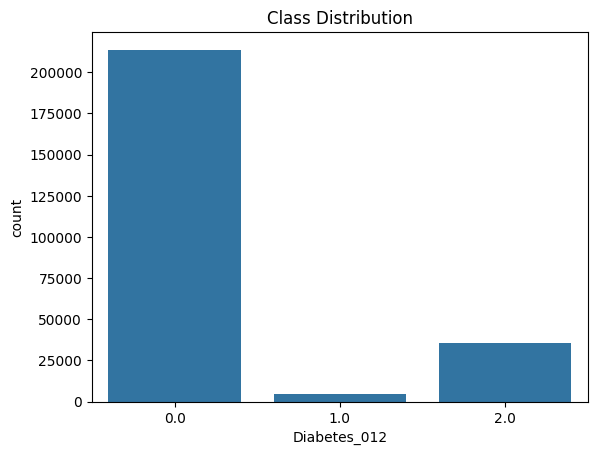

Summary Statistics:
        Diabetes_012         HighBP       HighChol  ...            Age      Education         Income
count  253680.000000  253680.000000  253680.000000  ...  253680.000000  253680.000000  253680.000000
mean        0.296921       0.429001       0.424121  ...       8.032119       5.050434       6.053875
std         0.698160       0.494934       0.494210  ...       3.054220       0.985774       2.071148
min         0.000000       0.000000       0.000000  ...       1.000000       1.000000       1.000000
25%         0.000000       0.000000       0.000000  ...       6.000000       4.000000       5.000000
50%         0.000000       0.000000       0.000000  ...       8.000000       5.000000       7.000000
75%         0.000000       1.000000       1.000000  ...      10.000000       6.000000       8.000000
max         2.000000       1.000000       1.000000  ...      13.000000       6.000000       8.000000

[8 rows x 22 columns]


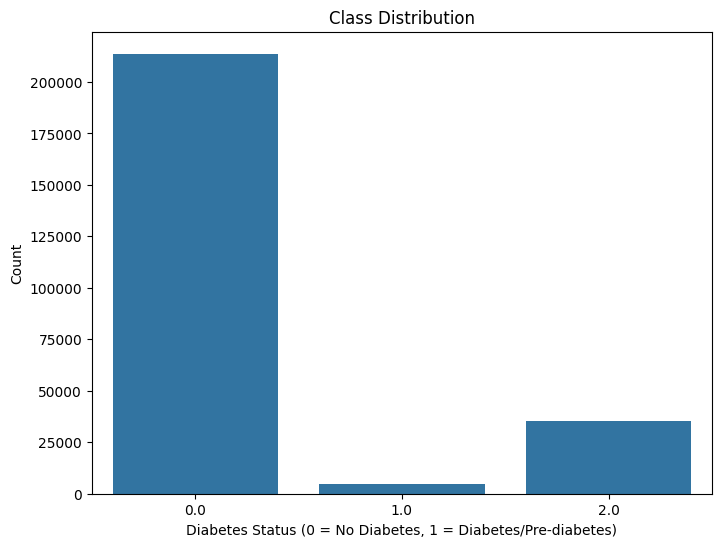

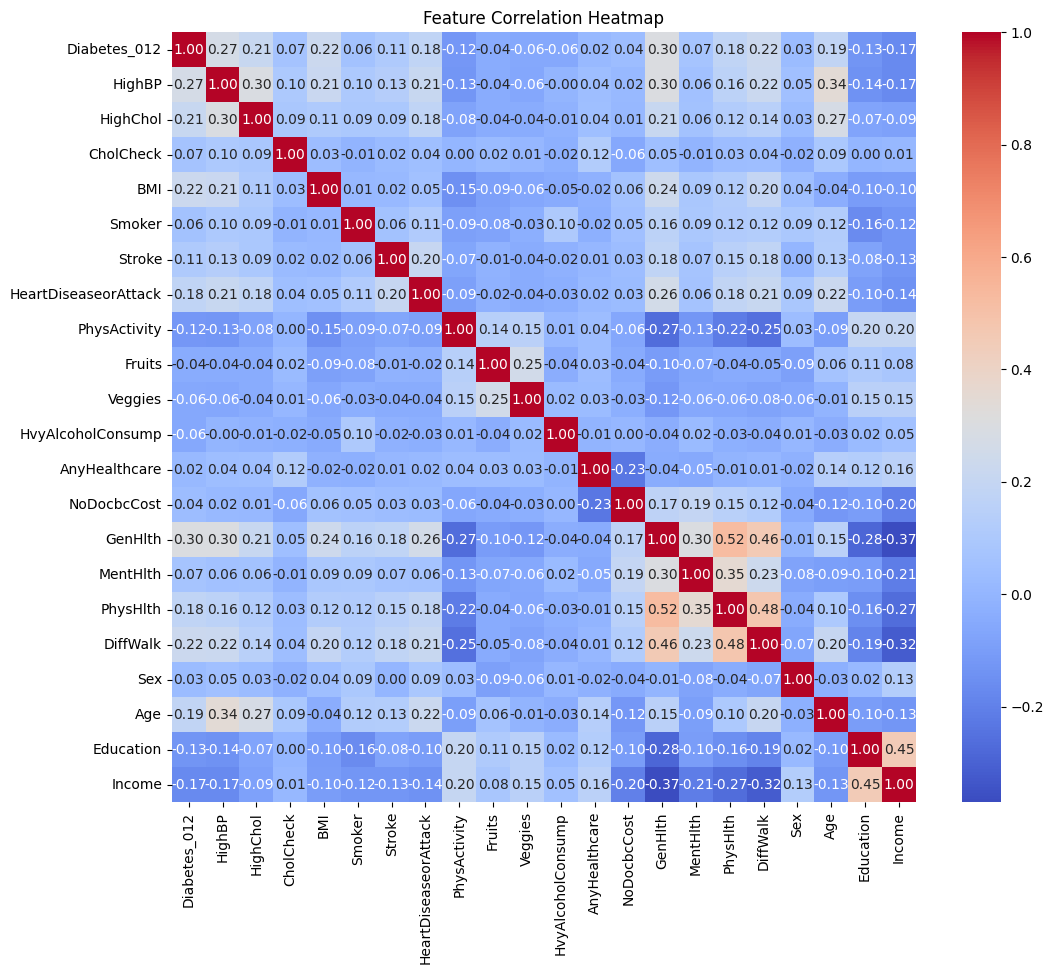

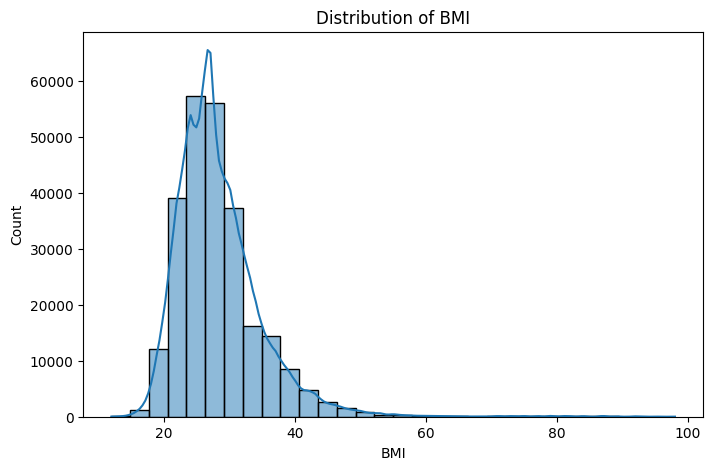

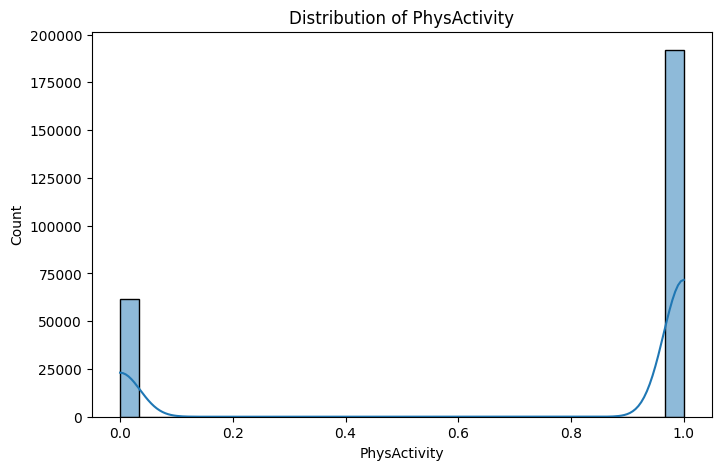

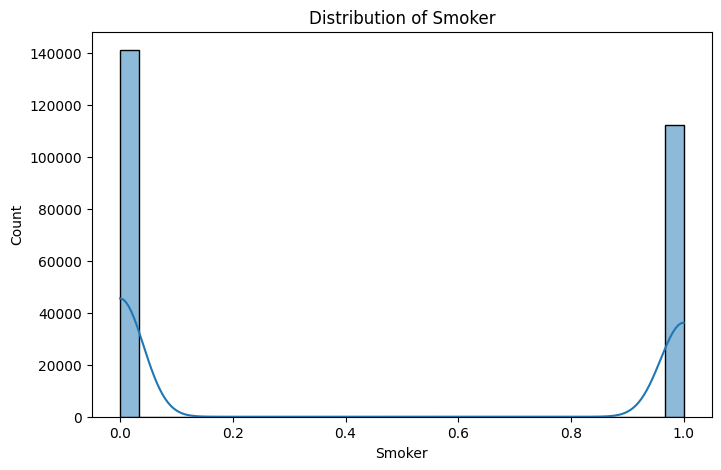

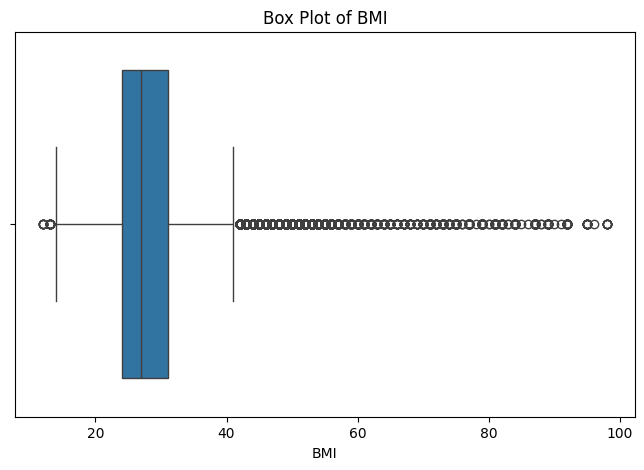

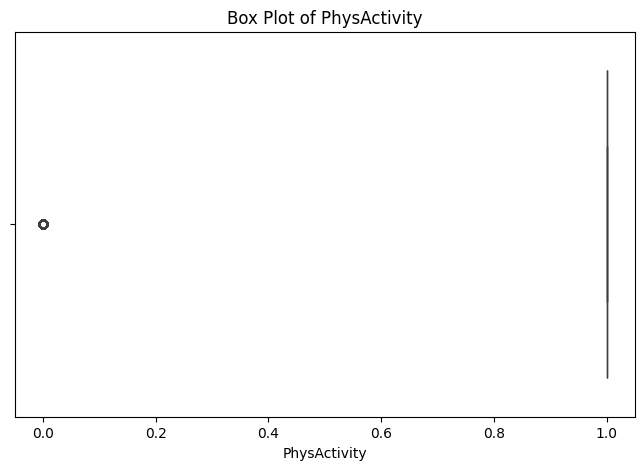

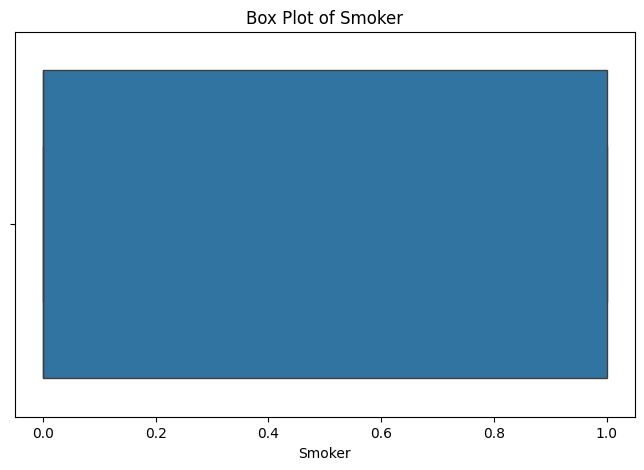

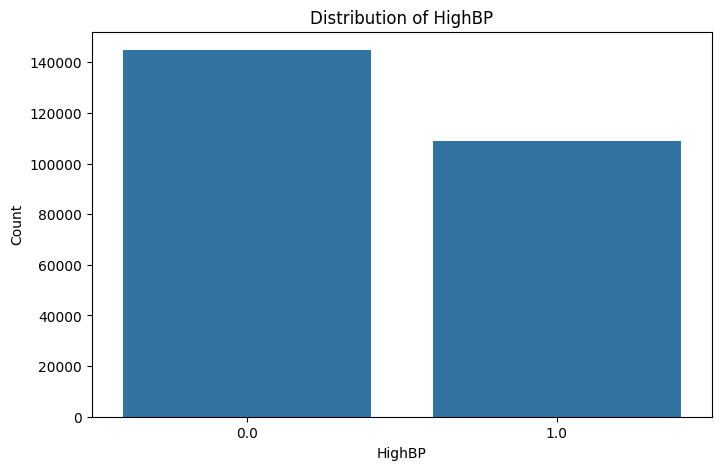

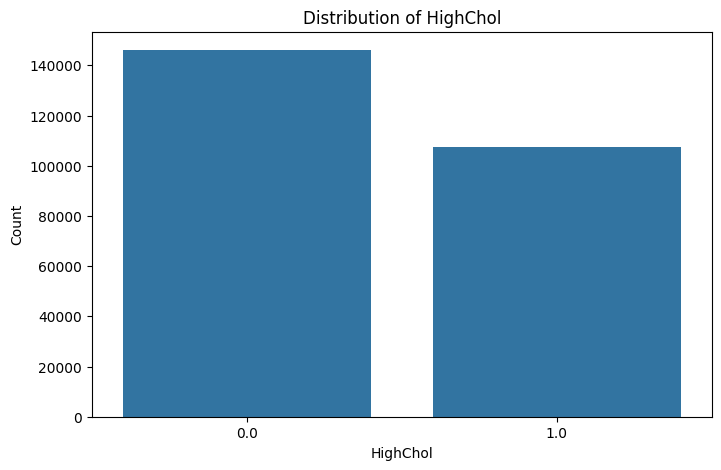

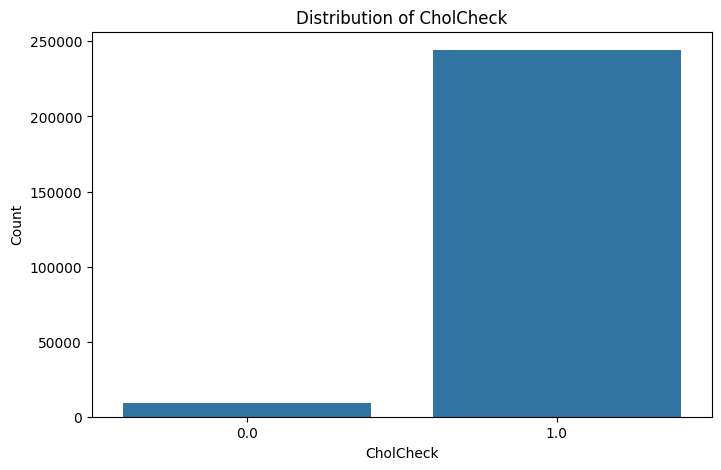

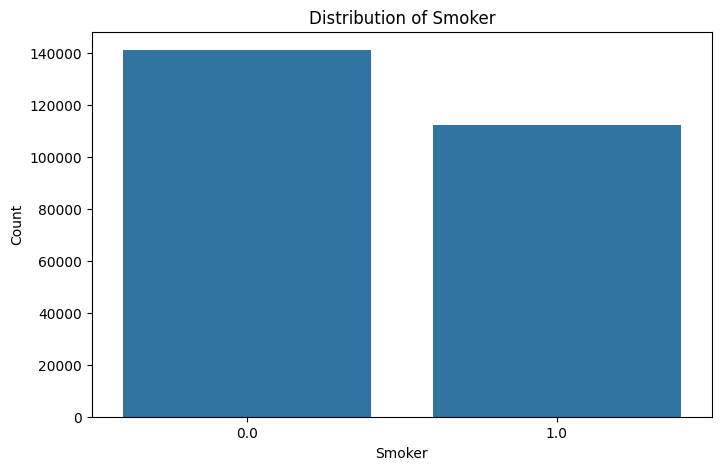

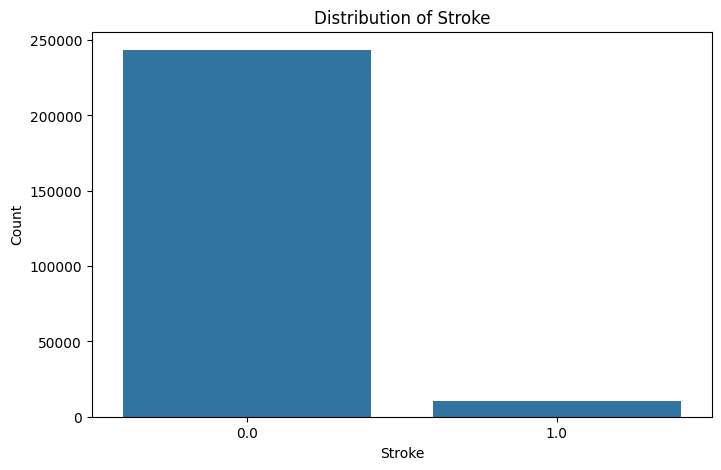

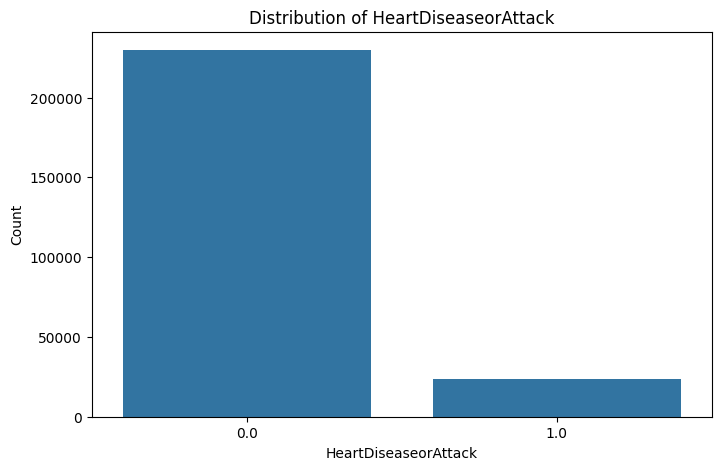

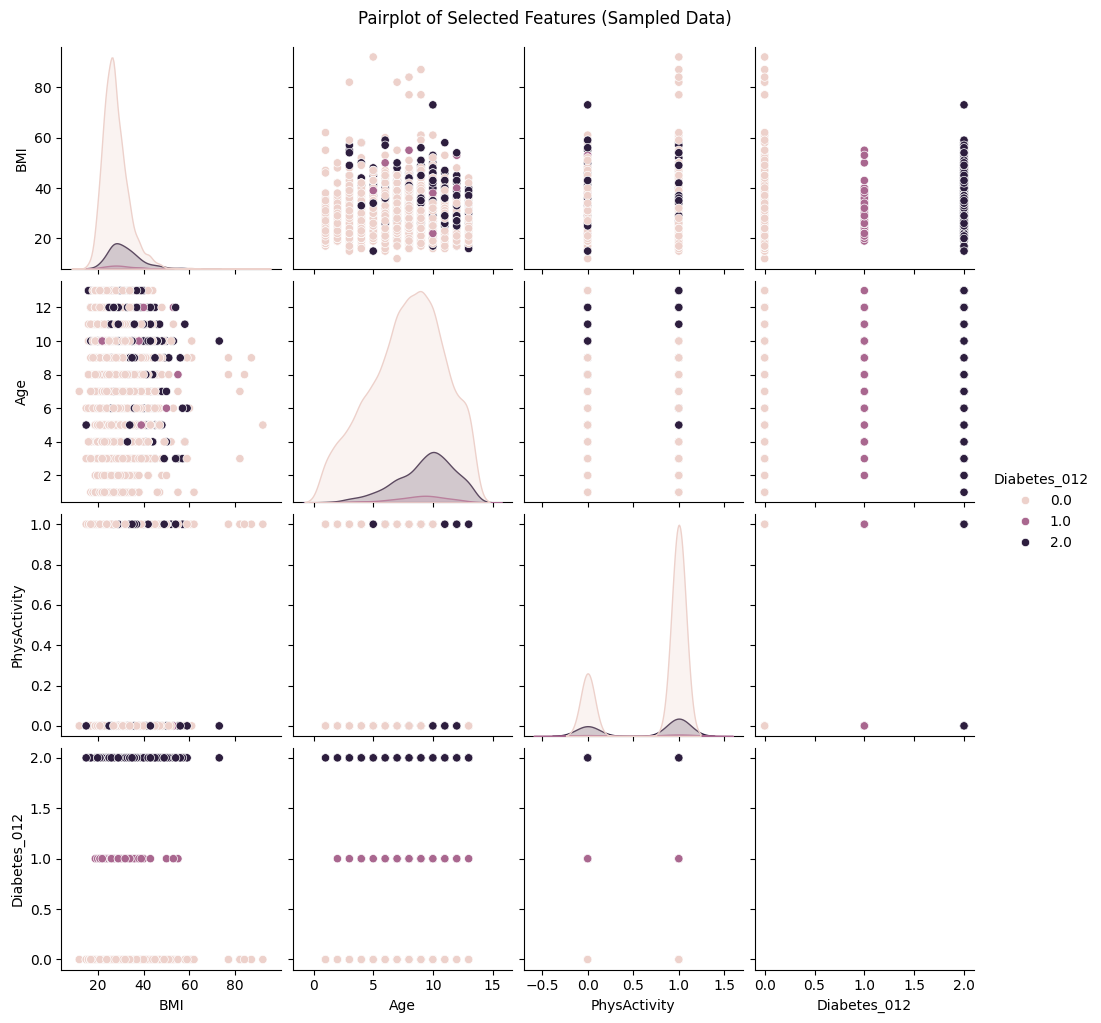

In [11]:
# Display info
print("Dataset Info:")
print(data.info())
print("\nMissing values:\n", data.isnull().sum())
print("\nClass Distribution:\n", data['Diabetes_012'].value_counts())

# class distribution
sns.countplot(x='Diabetes_012', data=data)
plt.title('Class Distribution')
plt.show()

# summary statistics
print("Summary Statistics:")
print(data.describe())

# class imbalance
plt.figure(figsize=(8, 6))
sns.countplot(x='Diabetes_012', data=data)
plt.title('Class Distribution')
plt.xlabel('Diabetes Status (0 = No Diabetes, 1 = Diabetes/Pre-diabetes)')
plt.ylabel('Count')
plt.show()

# correlations between features
plt.figure(figsize=(12, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Feature Correlation Heatmap')
plt.show()

# distribution of features
key_features = ['BMI', 'PhysActivity', 'Smoker']
for feature in key_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(data[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

# box plots for outliers
for feature in key_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=data[feature])
    plt.title(f'Box Plot of {feature}')
    plt.xlabel(feature)
    plt.show()

binary_features = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack']
for feature in binary_features:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=feature, data=data)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

# Pairplot for feature relationships
sampled_data = data.sample(5000, random_state=42)
pair_features = ['BMI', 'Age', 'PhysActivity', 'Diabetes_012']
sns.pairplot(sampled_data, hue='Diabetes_012', diag_kind='kde', vars=pair_features)
plt.suptitle('Pairplot of Selected Features (Sampled Data)', y=1.02)
plt.show()

Perform a train-dev-test split.

In [12]:
# split features and target
data['Diabetes_012'] = data['Diabetes_012'].apply(lambda x: 1 if x > 0 else 0)
X = data.drop(columns='Diabetes_012')
y = data['Diabetes_012']
# training, validation, and test sets (60% train, 20% dev, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# normalize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_dev = scaler.transform(X_dev)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_dev, y_dev = torch.tensor(X_dev, dtype=torch.float32), torch.tensor(y_dev.values, dtype=torch.float32).unsqueeze(1)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

Implement forward propagation (clearly describe the activation functions and other hyper-parameters you are using). Compute the final cost function.

In [15]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        X = self.hidden_layer(X)
        X = torch.relu(X)  # ReLU activation for hidden layer
        X = self.output_layer(X)
        X = self.sigmoid(X)  # Sigmoid activation for binary classification
        return X

# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 10
output_size = 1
learning_rate = 0.001
num_epochs = 1000

# init the model, loss function, and optimizer
model = NeuralNetwork(input_size, hidden_size, output_size)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Implement gradient descent (any variant of gradient descent depending upon your
data and project can be used) to train your model. In this step it is up to you as someone in charge of their project to improvise using optimization algorithms (Adams, RMSProp, etc.) and/or regularization. Experiment with normalized inputs i.e. comment on how your model performs when the inputs are normalized.

In [16]:
num_epochs = 1000
batch_size = 128
train_losses, dev_losses = [], []

for epoch in range(num_epochs):
    model.train()

    # Mini-batch gradient descent
    for i in range(0, X_train.size(0), batch_size):
        X_batch = X_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]

        # Forward pass
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # training loss
    train_losses.append(loss.item())
    # validation set
    model.eval()
    with torch.no_grad():
        y_pred_dev = model(X_dev)
        dev_loss = criterion(y_pred_dev, y_dev)
        dev_losses.append(dev_loss.item())

    # losses every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Training Loss: {loss.item():.4f}, Dev Loss: {dev_loss.item():.4f}")

Epoch 0, Training Loss: 0.5860, Dev Loss: 0.3484
Epoch 100, Training Loss: 0.4958, Dev Loss: 0.3409
Epoch 200, Training Loss: 0.4996, Dev Loss: 0.3410
Epoch 300, Training Loss: 0.5006, Dev Loss: 0.3410
Epoch 400, Training Loss: 0.5009, Dev Loss: 0.3410
Epoch 500, Training Loss: 0.5007, Dev Loss: 0.3410
Epoch 600, Training Loss: 0.5005, Dev Loss: 0.3410
Epoch 700, Training Loss: 0.5003, Dev Loss: 0.3411
Epoch 800, Training Loss: 0.4993, Dev Loss: 0.3411
Epoch 900, Training Loss: 0.4993, Dev Loss: 0.3411


Present the results using the test set.

In [17]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test)
    y_pred_test = (y_pred_test > 0.5).float()

# accuracy and classification metrics
accuracy = accuracy_score(y_test, y_pred_test)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))


Test Accuracy: 85.10%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.97      0.92     42741
         1.0       0.57      0.21      0.31      7995

    accuracy                           0.85     50736
   macro avg       0.72      0.59      0.61     50736
weighted avg       0.82      0.85      0.82     50736



For this part of the project, I implemented and trained a 2-layer neural network using PyTorch with mini-batch gradient descent and the Adam optimizer. The model consisted of an input layer, a hidden layer with ReLU activation, and an output layer using a sigmoid function for binary classification. I chose the Adam optimizer for its adaptive learning rate capabilities, which helps improve convergence speed. The binary cross-entropy loss function was used to measure how well the model's predictions matched the actual labels. Training was conducted for 1,000 epochs, with both training and validation (dev) losses tracked throughout the process.

During training, the initial loss started at 0.5860, indicating room for improvement in the model's predictions. Over time, the training loss gradually decreased to around 0.4993, while the dev loss stabilized at approximately 0.3410 after around 200 epochs. This stabilization suggests that the model converged without significant overfitting or underfitting. The use of normalized inputs contributed to this stability. Normalization, applied via StandardScaler, ensured that all features had similar ranges and variances, which allowed the model to learn efficiently without being affected by large differences in feature magnitudes. Without normalization, the model might have experienced slower convergence and fluctuating losses due to uneven gradients across features.

The test results showed a final accuracy of 85.10%, which indicates that the model is performing well overall. However, the classification report reveals an important issue with class imbalance. The precision and recall for the majority class (no diabetes) were high at 0.87 and 0.97, respectively, resulting in an F1-score of 0.92. In contrast, the minority class (diabetes) had a much lower recall of 0.21 and an F1-score of 0.31. This suggests that the model struggles to correctly identify instances of diabetes, likely because the dataset is imbalanced. As a result, the model prioritizes correctly classifying the majority class, which skews the performance metrics. The weighted average F1-score of 0.82 reflects this imbalance, as it is heavily influenced by the larger class.

Moving forward, I could apply techniques such as class weighting, oversampling the minority class, or using a loss function designed for imbalanced data to improve the model's performance on the minority class. Additionally, hyperparameter tuning, such as experimenting with hidden layer size, number of layers, or different optimizers like RMSprop, may further optimize performance. Overall, while the model performs well in terms of overall accuracy, addressing the class imbalance is necessary to achieve better recall for diabetic cases.

### Task 3

For task 2, I selected the hyperparameters based on a combination of best practices and experimentation. The input size was determined by the number of features in the dataset, while the hidden layer size was set to 10 neurons. I chose this value as a starting point to balance model complexity and training time. Adding too many hidden units could lead to overfitting, especially with relatively simple binary features, while too few units might limit the model’s ability to capture patterns in the data. The output size was set to 1, since this is a binary classification task. I also set the learning rate to 0.001, which is a common initial value for the Adam optimizer. This learning rate allows for stable updates while avoiding convergence issues due to excessively large or small steps.

I did not apply regularization (e.g., L1, L2 penalties, or dropout) for this initial implementation. This was because the model did not show significant signs of overfitting during training—both the training and dev losses stabilized around similar values. However, if I observed dev loss increasing while training loss continued to decrease, it would have indicated overfitting, prompting me to add regularization techniques to improve generalization.

For optimization, I used the Adam algorithm instead of basic stochastic gradient descent (SGD). Adam combines the benefits of momentum and adaptive learning rates, making it well-suited for handling datasets with varying feature scales. It adjusts the learning rate dynamically for each parameter, which helps the model converge faster and reduces the need for extensive manual learning rate tuning. Although other optimizers like RMSprop could have been used, Adam is known for its robust performance across various tasks, which is why I selected it.

Overall, these hyperparameters and optimization choices allowed the model to converge efficiently without overfitting. In future iterations, I could further experiment with hyperparameter tuning, such as increasing the hidden layer size, trying different learning rates, or incorporating regularization to see if they improve the model's ability to generalize, especially with the imbalanced data.

### Task 4

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# logistic regression model
baseline_model = LogisticRegression(max_iter=1000, class_weight='balanced')  # Using balanced class weights to handle class imbalance
baseline_model.fit(X_train, y_train.squeeze())  # Squeeze removes extra dimension

# Sevaluate the model on the test set
y_pred_test_baseline = baseline_model.predict(X_test)

# performance metrics
baseline_accuracy = accuracy_score(y_test, y_pred_test_baseline)
print(f"\nBaseline Model Test Accuracy: {baseline_accuracy * 100:.2f}%")
print("\nClassification Report (Baseline Model):\n", classification_report(y_test, y_pred_test_baseline))
# confusion matrix
print("\nConfusion Matrix (Baseline Model):\n", confusion_matrix(y_test, y_pred_test_baseline))


Baseline Model Test Accuracy: 72.99%

Classification Report (Baseline Model):
               precision    recall  f1-score   support

         0.0       0.94      0.72      0.82     42741
         1.0       0.34      0.77      0.47      7995

    accuracy                           0.73     50736
   macro avg       0.64      0.74      0.65     50736
weighted avg       0.85      0.73      0.76     50736


Confusion Matrix (Baseline Model):
 [[30913 11828]
 [ 1878  6117]]


The comparison between the neural network and the logistic regression baseline model highlights key differences in performance. The neural network achieved a higher test accuracy of 85.10%, while the logistic regression baseline had a lower accuracy of 72.99%. However, when examining the classification report in more detail, the two models demonstrate different strengths and weaknesses.

The neural network performed well at correctly identifying the majority class (no diabetes), with a precision of 0.87 and a recall of 0.97, leading to a strong F1-score of 0.92. However, it struggled with the minority class (diabetes), where the recall dropped to 0.21. This indicates that the neural network had difficulty detecting true positive cases of diabetes, likely due to class imbalance.

In contrast, the logistic regression baseline exhibited better balance in recall between the two classes. The recall for the diabetes class improved significantly to 0.77, suggesting that the baseline model was more sensitive to identifying diabetic cases. However, this came at the cost of precision, which dropped to 0.34 for the diabetes class. The high number of false positives led to a lower overall weighted F1-score of 0.76 compared to the neural network's 0.82.

These differences can be attributed to the models' underlying architectures and how they handle non-linearity. Logistic regression is a linear model, meaning it cannot capture complex relationships between features. However, it was able to improve recall for the minority class due to the class_weight='balanced' parameter, which adjusted the model to prioritize both classes more evenly. The neural network, on the other hand, is capable of modeling non-linear patterns but struggled with the imbalanced data despite its higher capacity for feature interaction.

Overall, the neural network outperformed logistic regression in terms of accuracy and precision but failed to match the baseline model's ability to detect diabetic cases. This comparison highlights the importance of balancing precision and recall depending on the problem's requirements. To improve the neural network’s performance on the minority class, techniques such as class reweighting, oversampling, or focal loss could be explored in future iterations.